## Install dependencies

In [1]:
#import sys
#!{sys.executable} --version
#!pwd

In [2]:
%pip install python-sat==0.1.7.dev19
%pip install networkx==2.6
%pip install matplotlib==3.5

Defaulting to user installation because normal site-packages is not writeable
--- Logging error ---
Traceback (most recent call last):
  File "/home/paulbrenker/.local/lib/python3.10/site-packages/pip/_internal/utils/logging.py", line 177, in emit
    self.console.print(renderable, overflow="ignore", crop=False, style=style)
  File "/home/paulbrenker/.local/lib/python3.10/site-packages/pip/_vendor/rich/console.py", line 1673, in print
    extend(render(renderable, render_options))
  File "/home/paulbrenker/.local/lib/python3.10/site-packages/pip/_vendor/rich/console.py", line 1305, in render
    for render_output in iter_render:
  File "/home/paulbrenker/.local/lib/python3.10/site-packages/pip/_internal/utils/logging.py", line 134, in __rich_console__
    for line in lines:
  File "/home/paulbrenker/.local/lib/python3.10/site-packages/pip/_vendor/rich/segment.py", line 249, in split_lines
    for segment in segments:
  File "/home/paulbrenker/.local/lib/python3.10/site-packages/pip/_ve

## Mit PySat können CNF Formeln beschrieben und auf Erfüllbarkeit geprüft werden:

In [3]:
from pysat.formula import CNF

f= CNF()
f.extend([[1,2,3],[-1,-2,3],[1,2,-3]])
print(f'Die Formel f hat die Klauseln: {f.clauses}')
print(f'Die Klauseln in f haben {f.nv} Variablen')

Die Formel f hat die Klauseln: [[1, 2, 3], [-1, -2, 3], [1, 2, -3]]
Die Klauseln in f haben 3 Variablen


### Nun prüfen wir mit dem Solver Glucose3, ob f erfüllbar ist:

In [4]:
from pysat.solvers import Glucose3
s = Glucose3()
s.append_formula(f)

print(f'ist die Formel erfüllbar? {s.solve()}')
print(f'was wäre ein Modell? {s.get_model()}')
models=[m for m in s.enum_models()]
print(f'Insgesamt gibt es {len(models)} Modelle: {models}')    

ist die Formel erfüllbar? True
was wäre ein Modell? [1, -2, -3]
Insgesamt gibt es 5 Modelle: [[1, -2, -3], [1, -2, 3], [-1, 2, 3], [1, 2, 3], [-1, 2, -3]]


### wir können auch die charakteristische Funktion von 3SAT explizit definieren:

In [5]:
from pysat.solvers import Glucose3
def chi_3SAT(f):
    print("hier müsste eigentlich noch geprüft werden ob f eine 3KNF Formel ist")
    s = Glucose3()
    s.append_formula(f)
    return s.solve()
print(chi_3SAT(f))

hier müsste eigentlich noch geprüft werden ob f eine 3KNF Formel ist
True


## Mit NetworkX können wir Graphen definieren:

In [6]:
import networkx as nx
from networkx.generators.small import *
#G = house_x_graph()
#G = house_graph()
G = nx.Graph([(2, 3), (2, 5), (3, 4), (1, 4), (4, 6), (4, 5), (5, 7), (7, 6), (6,1)])

print(G)

Graph with 7 nodes and 9 edges


### und auch plotten

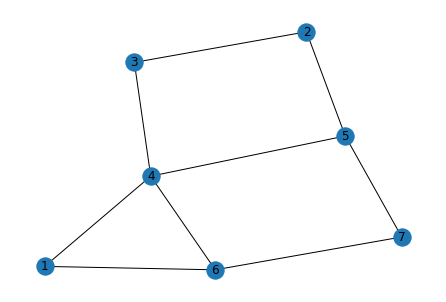

In [7]:
import matplotlib.pyplot as plt
nx.draw(G, with_labels=True)

### wir können diverse Informationen über den Graph und seine Knoten/Kanten erhalten:

In [8]:
from networkx.algorithms.clique import *

for n,d in G.degree():
    print(f'node {n} has degree {d}')
print(f'Biggest Clique in Graph has size {graph_clique_number(G)}')

node 2 has degree 2
node 3 has degree 2
node 5 has degree 3
node 4 has degree 4
node 1 has degree 2
node 6 has degree 3
node 7 has degree 2
Biggest Clique in Graph has size 3


### und z.B. eine größte Clique visualisieren:

[4, 1, 6]


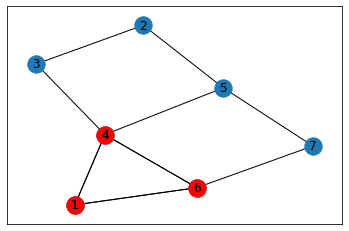

In [9]:
k=graph_clique_number(G)
for c in find_cliques(G):
    if len(c)==k :
        print(c)
        sub=G.subgraph(c)
        pos=nx.spring_layout(G)
        nx.draw_networkx(G,pos=pos)
        nx.draw_networkx(sub,pos=pos, node_color='r')

### oder auch explizit die charakteristische Funktion von k-Clique definieren

In [10]:
from networkx.algorithms.clique import *
def chi_k_CLIQUE(G,k):
        return graph_clique_number(G) >= k
print(chi_k_CLIQUE(G,3))
print(chi_k_CLIQUE(G,4))

True
False


### Man kann z.B. eine Funktion schreiben, die einen Hamilton-Pfad finden (wenn einer vorhanden ist)
(vgl. https://gist.github.com/mikkelam/ab7966e7ab1c441f947b, Vorsicht, Laufzeit ist exponenziell)

In [11]:
def hamilton(G):
    F = [(G,[list(G.nodes())[0]])]
    n = G.number_of_nodes()
    while F:
        graph,path = F.pop()
        confs = []
        neighbors = (node for node in graph.neighbors(path[-1]) 
                     if node != path[-1]) #exclude self loops
        for neighbor in neighbors:
            conf_p = path[:]
            conf_p.append(neighbor)
            conf_g = nx.Graph(graph)
            conf_g.remove_node(path[-1])
            confs.append((conf_g,conf_p))
        for g,p in confs:
            if len(p)==n and p[-1] in G.neighbors(p[0]):
                #p.append((p[-1],p[0]))
                return p
            else:
                F.append((g,p))
    return None

### und einen Hamilton-Pfad suchen und visualisieren

Der Graph enthält den Hamilton Pfad [2, 5, 7, 6, 1, 4, 3]


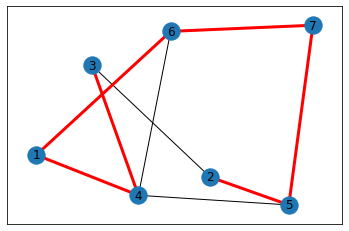

In [12]:
e=hamilton(G)
print(f'Der Graph enthält den Hamilton Pfad {e}')
p=[[u,v] for u,v in zip(e[:-1], e[1:])]
pos=nx.spring_layout(G)
nx.draw_networkx(G,pos)
nx.draw_networkx_edges(G,pos,edgelist=p,edge_color='r',width=3)

## Nun zu den Reduktionen:
### 3SAT $\leq_p$ Clique
- Implementieren Sie einen (polynomiellen) Reduktions-Algorithmus, um die Erfüllbarkeit von 3-KNF Formeln auf das k-Cliquen-Problem zu reduzieren und testen Sie Ihren Algorithmus.
- Welche Laufzeit hat Ihr Algorithmus zum Testen auf Erfüllbarkeit?  



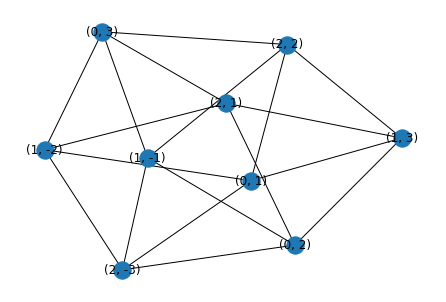

Graph with 9 nodes and 18 edges
Biggest Clique in Graph has size 3
Models for KNF resulting from clique finding: [[-3, -2, 1], [1, 2, 3], [-2, 1, 3], [-1, 2, 3], [-3, -1, 2]]


In [13]:
f= CNF()
f.extend([[1,2,3],[-1,-2,3],[1,2,-3]])
V = []
for i in range(len(f.clauses)):
    for j in range(i,len(f.clauses)):
        if f.clauses[i] != f.clauses[j]:
            for p in f.clauses[i]:
                for q in f.clauses[j]:
                    if (-p != q) and (p != q):
                        V.append(((i,p),(j,q)))
G = nx.Graph(V)
nx.draw(G, with_labels=True)
plt.show()
print (G)

#
print(f'Biggest Clique in Graph has size {graph_clique_number(G)}')
k=graph_clique_number(G)
cs = []
for c in find_cliques(G):
    if len(c)==k :
        c = [x[1] for x in c]
        c.sort()
        if (len(set(c)) == len(c)):   #eliminate shorts
            cs.append(tuple(c))
            

cs = list(set(cs))   #eliminate duplicates
cs = [list(c) for c in cs]
print(f'Models for KNF resulting from clique finding: {cs}')



#Reduktionsalgorithmus hat Laufzeit O(n * (n/2) * 3 * 3) = O(n²) ... für mSAT Probleme hat der Algorithmus Laufzeit von O(n²m²) -> polynomielle Laufzeit
#Ergebnisse für Cliquen im Graph müssen von Duplikaten und Zweierkombinationen bereinig werden für Ausgabe.


### 3SAT $\leq_p$ DHC $\leq_p$ UHC $\leq_p$ TSP (optional)
- Implementieren Sie (polynomielle) Reduktions-Algorithmen, um die Erfüllbarkeit von 3-KNF Formeln auf DHC und danach auf UHC zu reduzieren und testen Sie Ihre Reduktionen mittels des oben angegebenen UHC Algorithmus.
- Implementieren Sie einen exakten Algorithmus für das TSP Problem (Backtracking) und reduzieren Sie UHC $\leq_p$ TSP (optional)

In [14]:
def visualize(G):
    nx.draw(G, with_labels=True)
    plt.show()
    return

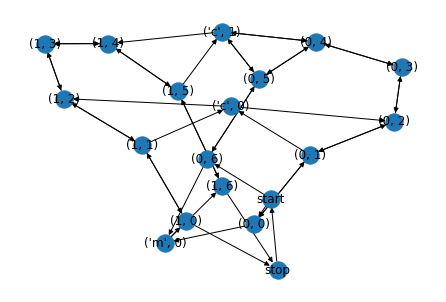

Der Graph enthält den Hamilton Pfad ['start', (0, 6), ('m', 0), (1, 6), 'stop', (1, 0), (1, 1), ('c', 0), (1, 2), (1, 3), (1, 4), (1, 5), ('c', 1), (0, 5), (0, 4), (0, 3), (0, 2), (0, 1), (0, 0)]


In [15]:
def three_sat_to_dhc(f: CNF):
    #find set of variables
    var = [item for sublist in f.clauses for item in sublist]
    var = set({abs(x) for x in var})
    n = len(var)
    k = len(f.clauses)
    
    #create diamond shaped graph
    V=[('start',(0,0)),('start',(0,3*k)),((n-1,0),'stop'),((n-1,3*k),'stop')]
    for i in range(0,n):
        for j in range(0,3*k):
            V.append(((i,j),(i,j+1)))
            V.append(((i,j+1),(i,j)))
        if i < n-1:
            V.append(((i,0),('m',i)))
            V.append(((i,3*k),('m',i)))
            V.append((('m',i),(i+1,0)))
            V.append((('m',i),(i+1,3*k)))
            
    #create clause nodes
    j = 0
    for clause in f.clauses:
        for i in range(1,n+2):
            if i in clause:
                V.append(((i-1,j*3+1),('c',j)))
                V.append((('c',j),(i-1,j*3+2)))
            if -i in clause:
                V.append(((i-1,j*3+2),('c',j)))
                V.append((('c',j),(i-1,j*3+1)))
        j = j+1
    V.append(('stop','start'))
    return nx.DiGraph(V)

f= CNF()
f.extend([[1,2,1],[-2,1,-1]]) #use variables 1-n
DHC = three_sat_to_dhc(f)
visualize(DHC)
e=hamilton(DHC)
print(f'Der Graph enthält den Hamilton Pfad {e}')

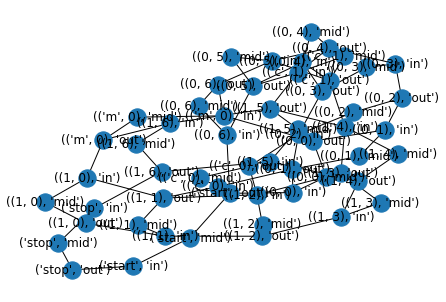

In [16]:
def dhc_to_uhc(DHC: nx.DiGraph):
    V=[]
    for node in DHC.nodes:
        V.append(((node,'mid') , (node,'in')))
        V.append(((node,'mid'), (node,'out')))
                  
    for edge in DHC.edges:
        V.append(((edge[0],'out'),(edge[1],'in')))
    
    return nx.Graph(V)
        

UHC = dhc_to_uhc(DHC)
visualize(UHC)

Der Graph enthält den Hamilton Pfad [('start', 'mid'), ('start', 'out'), ((0, 6), 'in'), ((0, 6), 'mid'), ((0, 6), 'out'), ((0, 5), 'in'), ((0, 5), 'mid'), ((0, 5), 'out'), (('c', 1), 'in'), (('c', 1), 'mid'), (('c', 1), 'out'), ((0, 4), 'in'), ((0, 4), 'mid'), ((0, 4), 'out'), ((0, 3), 'in'), ((0, 3), 'mid'), ((0, 3), 'out'), ((0, 2), 'in'), ((0, 2), 'mid'), ((0, 2), 'out'), ((0, 1), 'in'), ((0, 1), 'mid'), ((0, 1), 'out'), ((0, 0), 'in'), ((0, 0), 'mid'), ((0, 0), 'out'), (('m', 0), 'in'), (('m', 0), 'mid'), (('m', 0), 'out'), ((1, 0), 'in'), ((1, 0), 'mid'), ((1, 0), 'out'), ((1, 1), 'in'), ((1, 1), 'mid'), ((1, 1), 'out'), (('c', 0), 'in'), (('c', 0), 'mid'), (('c', 0), 'out'), ((1, 2), 'in'), ((1, 2), 'mid'), ((1, 2), 'out'), ((1, 3), 'in'), ((1, 3), 'mid'), ((1, 3), 'out'), ((1, 4), 'in'), ((1, 4), 'mid'), ((1, 4), 'out'), ((1, 5), 'in'), ((1, 5), 'mid'), ((1, 5), 'out'), ((1, 6), 'in'), ((1, 6), 'mid'), ((1, 6), 'out'), ('stop', 'in'), ('stop', 'mid'), ('stop', 'out'), ('start',

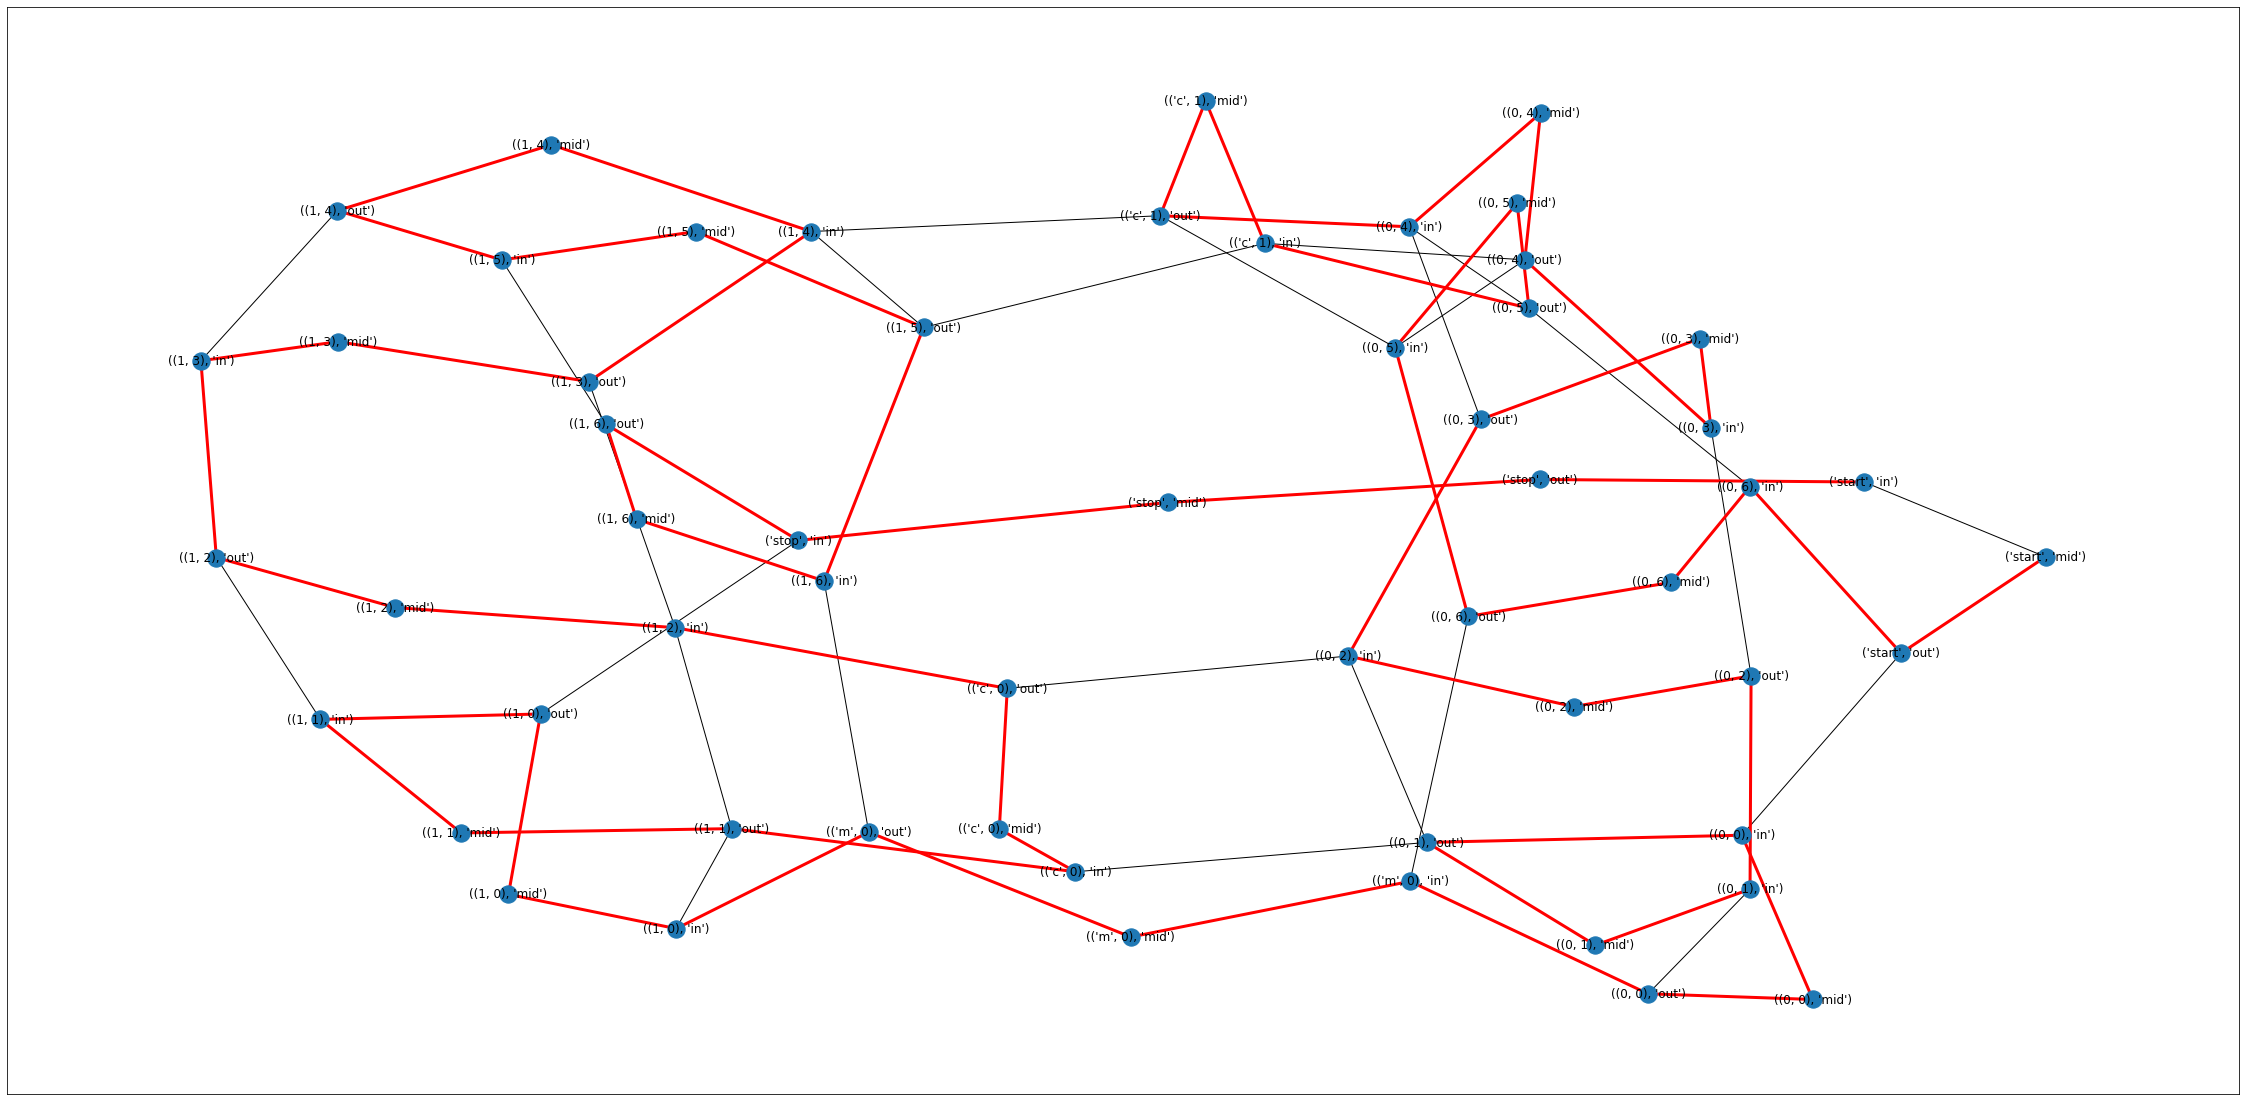

In [17]:
e=hamilton(UHC)
print(f'Der Graph enthält den Hamilton Pfad {e}')
if e is None : pass
else:
    p=[[u,v] for u,v in zip(e[:-1], e[1:])]
    pos=nx.spring_layout(UHC)
    plt.figure(figsize=(40,20))
    nx.draw_networkx(UHC,pos)
    nx.draw_networkx_edges(UHC,pos,edgelist=p,edge_color='r',width=3)
    plt.show()

In [18]:
import itertools

def uhc_to_tsp(UHC: nx.Graph):
    TSP = nx.Graph()
    TSP.add_nodes_from(list(UHC.nodes))
    for (u,v) in itertools.combinations(list(TSP.nodes), 2):
        TSP.add_edge(u,v)
        if (u,v in list(UHC.edges)):
            TSP[u][v]['length'] = 1
        else:
            TSP[u][v]['length'] = 2
    return TSP
    